In [1]:
import cv2 as cv2
import numpy as np
import os
from os import listdir
import matplotlib.pyplot as plt
import pywt
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


## 1. Data import and visualisation

In [2]:
def load_images_to_list(dir, color_convertion = None):
    images = []
    for filename in os.listdir(dir):
        if filename.lower().endswith(".png") or filename.lower().endswith('.jpg') or filename.lower().endswith('.jpeg'):
            image_path = os.path.join(dir, filename)
            image = cv2.imread(image_path)

            if color_convertion == 'BGR2RGB':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            elif color_convertion == 'RGB2BGR':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            elif color_convertion == 'RGB2GRAY':
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            elif color_convertion == 'BGR2GRAY':
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
            if image is not None:
                images.append(image)

    return images

In [3]:
classes = ["Barack Obama", "Donald Trump", "Joe Biden"]
images_raw = {}

In [ ]:
for class_ in classes:
    images_raw[class_] = load_images_to_list(fr"images/{class_}/", color_convertion = "BGR2RGB")

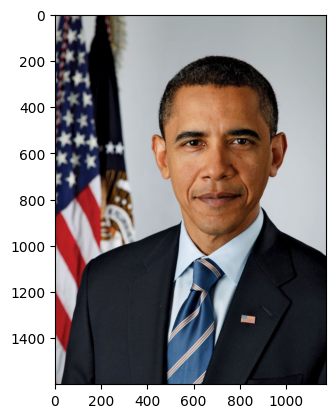

In [4]:
plt.imshow(images_raw["Barack Obama"][1])

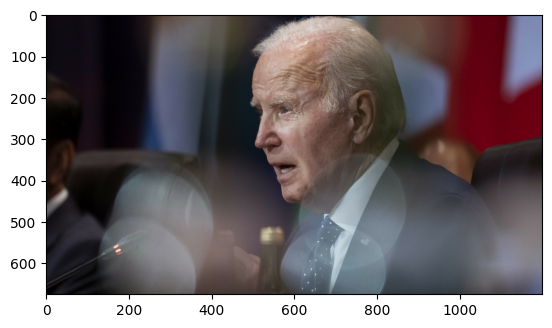

In [5]:
plt.imshow(images_raw["Joe Biden"][1])

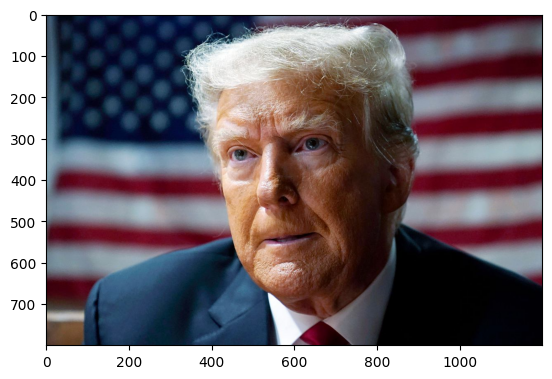

In [6]:
plt.imshow(images_raw["Donald Trump"][1])

## 2. Extracting faces from images

In [7]:
def detect_largest_face(image, output_path):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    faces = face_cascade.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    largest_face = None
    largest_area = 0
    for (x, y, w, h) in faces:
        area = w * h
        if area > largest_area:
            largest_area = area
            largest_face = (x, y, w, h)

    if largest_face is not None:
        (x, y, w, h) = largest_face
        cropped_face = image_gray[y:y+h, x:x+w]
        cv2.imwrite(output_path, cropped_face)

In [9]:
for class_ in classes:
    for id, image in enumerate(images_raw[class_]):
        detect_largest_face(image, f'face_images/{class_}/{id}.PNG')

In [10]:
face_images = {}

for class_ in classes:
    face_images[class_] = load_images_to_list(fr"face_images/{class_}/", "BGR2GRAY")
    print(f"{class_}: number of samples: {len(face_images[class_])}")

Barack Obama: number of samples: 461
Donald Trump: number of samples: 429
Joe Biden: number of samples: 507


In [4]:
def display_samples(class_name):
    fig, ax = plt.subplots(3, 4)

    for i, ax in enumerate(ax.flat):
        ax.imshow(face_images[class_name][i], cmap='gray')
        ax.set(xticks=[], yticks=[],
                xlabel=class_name)

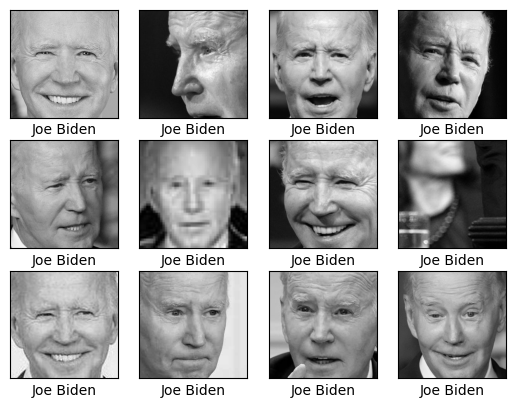

In [11]:
display_samples("Joe Biden")

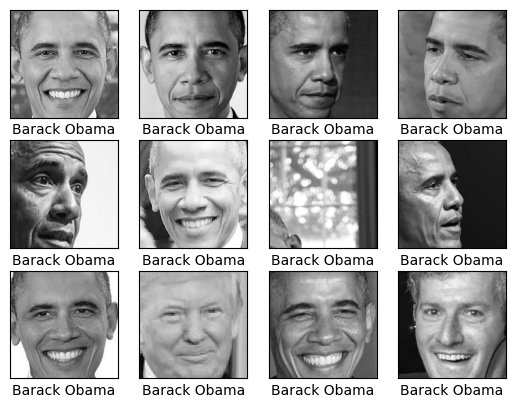

In [12]:
display_samples("Barack Obama")

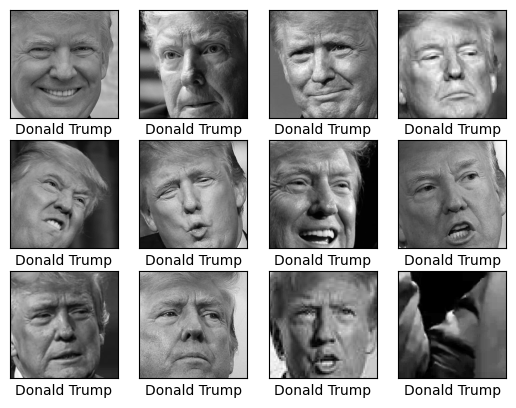

In [13]:
display_samples("Donald Trump")

### Photos with detected faces require manual selection

In [5]:
face_images = {}

for class_ in classes:
    face_images[class_] = load_images_to_list(fr"face_images/{class_}/", "BGR2GRAY")
    print(f"{class_}: number of samples: {len(face_images[class_])}")

Barack Obama: number of samples: 340
Donald Trump: number of samples: 318
Joe Biden: number of samples: 370


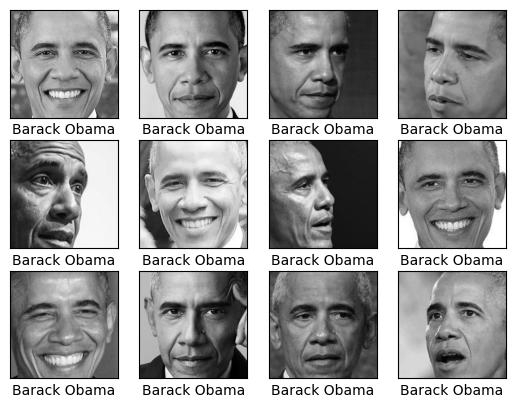

In [6]:
display_samples("Barack Obama")

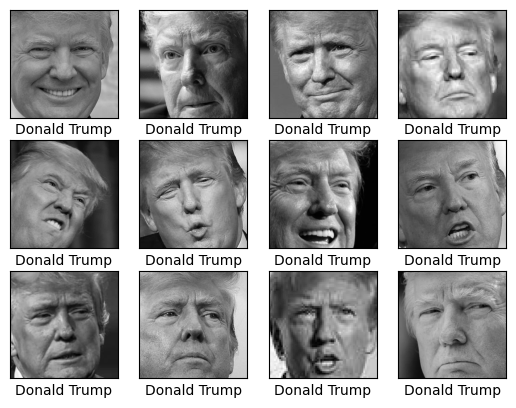

In [7]:
display_samples("Donald Trump")

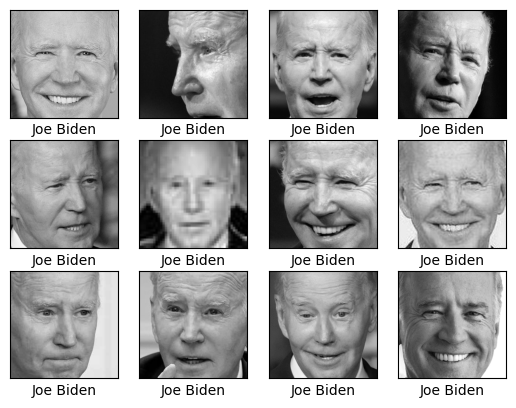

In [8]:
display_samples("Joe Biden")

## 3. Preparation of training data

In [9]:
data = []

for idx, class_ in enumerate(classes):
    for image in face_images[class_][:315]:
        image = cv2.resize(image, (64,64))
        image = np.array(image).flatten() / 255.
        data.append([image, idx])

In [10]:
len(data)

945

In [11]:
features = []
labels = []
for feature, label in data:
    features.append(feature)
    labels.append(label)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

### Visualisation of training data

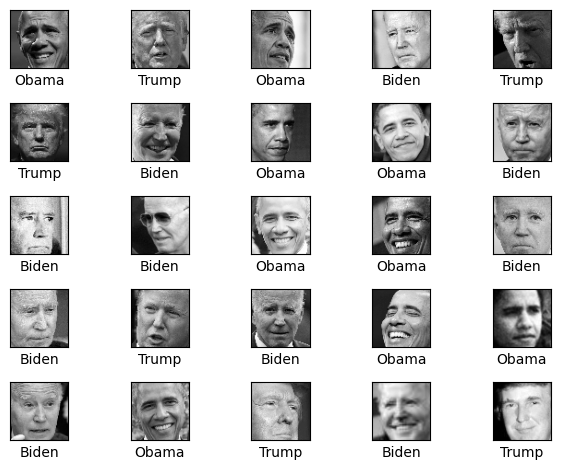

In [13]:
fig, ax = plt.subplots(5, 5)

for i, ax in enumerate(ax.flat):
    ax.imshow(x_train[i].reshape(64, 64), cmap='gray')
    ax.set(xticks=[], yticks=[],
            xlabel=classes[y_train[i]].split()[1])

fig.tight_layout()

## 4. SVM training

In [14]:
model = SVC(C=5, kernel='rbf', gamma='auto')
model.fit(x_train, y_train)

SVC(C=5, gamma='auto')

In [15]:
y_pred = model.predict(x_test)
accuracy_train = model.score(x_train, y_train)
print(f'Train accuracy: {round(accuracy_train * 100, 2)}%')

accuracy_test = model.score(x_test, y_test)
print(f'Test accuracy: {round(accuracy_test * 100, 2)}%')

Train accuracy: 84.79%
Test accuracy: 76.72%


In [16]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

Barack Obama       0.77      0.81      0.79        63
Donald Trump       0.91      0.75      0.82        68
   Joe Biden       0.64      0.74      0.69        58

    accuracy                           0.77       189
   macro avg       0.78      0.77      0.77       189
weighted avg       0.78      0.77      0.77       189



In [17]:
def print_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='g',
                xticklabels=classes,
                yticklabels=classes,
        )
    plt.ylabel('Prediction', fontsize=13)
    plt.xlabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17)
    plt.show()

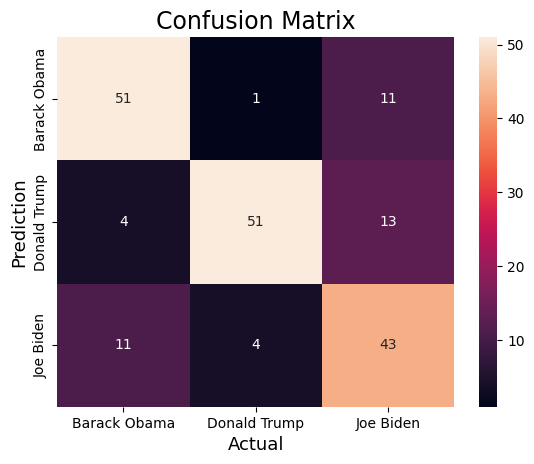

In [18]:
print_confusion_matrix(y_test, y_pred)

Accuracy of 76.72% on the test set is not bad, but we can increase it by hyperparameter tuning using the grid search method.

## 5. Hyperparameter tuning

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 5, 10, 50, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly', 'linear']}

grid_model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=3)
grid_model.fit(x_train, y_train)

In [20]:
print(grid_model.best_params_)
print(grid_model.best_estimator_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)


In [21]:
y_pred = grid_model.predict(x_test)
accuracy_train = grid_model.score(x_train, y_train)
print(f'Train accuracy: {round(accuracy_train * 100, 2)}%')

accuracy_test = grid_model.score(x_test, y_test)
print(f'Test accuracy: {round(accuracy_test * 100, 2)}%')

Train accuracy: 97.09%
Test accuracy: 86.24%


In [22]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

Barack Obama       0.84      0.92      0.88        63
Donald Trump       0.94      0.87      0.90        68
   Joe Biden       0.81      0.79      0.80        58

    accuracy                           0.86       189
   macro avg       0.86      0.86      0.86       189
weighted avg       0.86      0.86      0.86       189



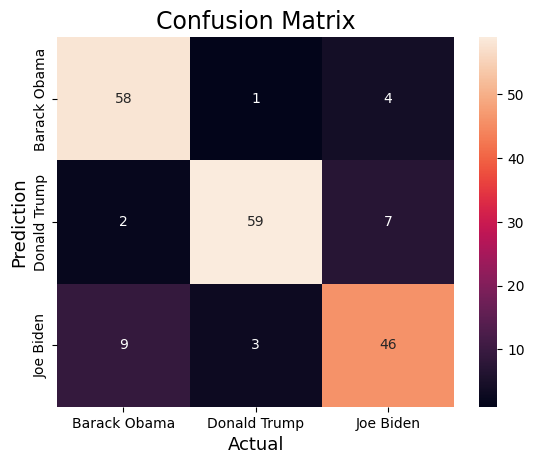

In [23]:
print_confusion_matrix(y_test, y_pred)

We achieved an accuracy of 86.24% on the test set. Let's visualize some of the incorrect predictions. 

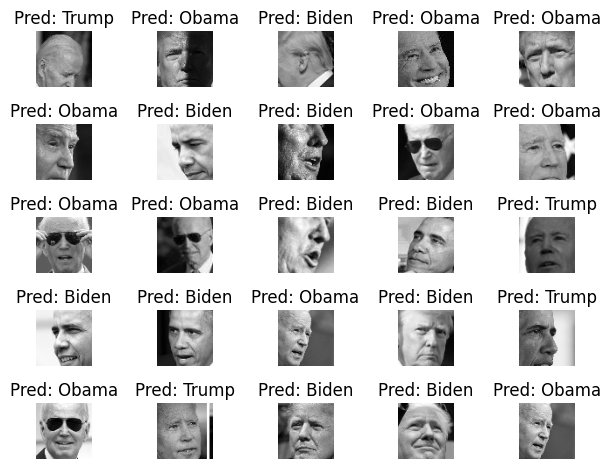

In [50]:
missclass_idx = np.where(y_test != y_pred)[0]

for i in range(25):
    index = missclass_idx[i]
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    plt.title(f"Pred: {classes[y_pred[index]].split()[1]}")
    plt.axis('off')

plt.tight_layout()
plt.show()